# [Parameter efficient fine tuning using LORA](https://arxiv.org/pdf/2106.09685.pdf)

LoRA is a relatively new technique for adapting LLMs to specific downstream tasks. LoRA works by freezing the pre trained model weights and and injecting trainable rank decomposition matrices into each layer of the transformer architecture. This greatly reduces the number of trainable parameters required, and hence reducing the resources required i.e. reduced memory usage while training, and reduced disk space for checkpoints. This allows for fine tuning of relatively large models using basic hardware. This example uses [huggingface PEFT](https://huggingface.co/docs/diffusers/training/lora) libraries that use the LORA technique for parameter efficient fine tuning of Roberta-Large (355M parameters).

This work is built on the premise that pre trained models have a low intrinsic "rank" i.e. The number of linearly independent rows or columns. Therefore it follow that changes in these pre trained weights as a result of task specific fune tuning must also has a low intrinsic rank.

Assuming the base model weights to be $W_ox$ and $\varDelta Wx$ to be the changes due to fine tuning, then the fine tuned weights can be expressed as $h=Wox+\varDelta Wx$. Further the LoRA adapters create a low rank decomposition $\varDelta Wx = BA$ resulting in $h=W_0x+BAx$

Concrete example:
If a weight matrix is of size = $d=5000$, $k=3000$, $d \times k = 15,000,000$ parameters; using $r=6$ we get $(d \times r) + (r \times k) = 30000 + 18000 = 48,000$ parameters, which is 0.3% of the size



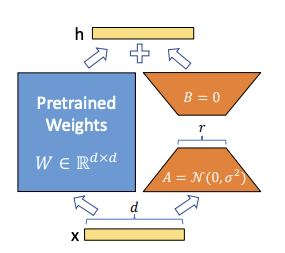

In [1]:
!pip install -q -U datasets
!pip install -q -U transformers[torch]
!pip install -q -U evaluate
!pip install -q -U peft
!pip install -q -U accelerate

In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import evaluate
import torch
import numpy as np

model_checkpoint = "roberta-large"
lr = 1e-5
batch_size = 8
num_epochs = 2


### Set LORA specific hyperparameters

`r` is the rank of the

In [3]:
r = 8
lora_alpha = 32
lora_dropout = 0.1

## Load IMDB Dataset
reduce dataset size to 10K to reduce tuning time

In [4]:
imdb = load_dataset("imdb")
for key in imdb.keys():
    imdb[key] = imdb[key].shuffle().select((range(10000)))


## This function gets used during evaluation

In [5]:
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


## Tokenize input text

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
def tokenize(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

    return tokenized_inputs


In [8]:
tokenized_imdb = imdb.map(tokenize, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Load classification model.

`AutoModelForSequenceClassification` is a Generic huggingface transformers library that has a classification head on top of model outputs. We freeze the model layers explicitly since the LORA adapters will be used to train smaller weight matrices

In [9]:
id2label = {
    0: "neg",
    1: "pos"
}

label2id = {
    "neg": 0,
    "pos": 1
}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)
for name, param in model.named_parameters():
    param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## LORA setup
setup the lora config and call function to get the peft version of the model that adds the extra adapters and layers

In [10]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout
)

In [11]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 1,838,082 || all params: 357,199,876 || trainable%: 0.5146


In [12]:
_= model.to("cuda")

## Setup training arguments and train model

In [13]:
training_args = TrainingArguments(
    output_dir="roberta-large-lora-sequence-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to='none'
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


TrainOutput(global_step=2500, training_loss=0.28988060613274574, metrics={'train_runtime': 6341.5143, 'train_samples_per_second': 3.154, 'train_steps_per_second': 0.394, 'total_flos': 1.875155902464e+16, 'train_loss': 0.28988060613274574, 'epoch': 2.0})

## Run a sample evaluation

In [15]:
#Run an example inference on a few rows in test dataset
examples = tokenized_imdb["test"].select(range(5))
result = trainer.predict(examples)
for ex, pred in zip(examples, result.label_ids):
    print(ex['text'][:150], id2label[pred])






I couldn't even sit through the whole thing! This movie was a piece of crap! I had more fun watching "Dont' Tell Mom The Babysitter's Dead"! It was ju neg
I went straight to the big screen to view this kicker. This is the only flick that I know of that Tarsem Singh has directed but boy was it intense. Th pos
Ugh. This movie has so many unbelievable plot contrivances that they made what could have been a good movie into a hideous mess. The story is halfway  neg
Alexander Nevsky is a series of superb sequences of cinematic opera that pass from pastoral to lamentation and end in a triumphal cantata. The story t pos
This series is vastly underrated. Like many others, I came upon Farscape after the series had been cancelled. Bought Season 1 and was surprised to fin pos


## Size of checkpoints

In [16]:
# print and check size of checkpoint. As expected the model size is much smaller that a typical bert checkpoint
!ls -lh roberta-large-lora-sequence-classification/checkpoint-1250/


total 22M
-rw-r--r-- 1 root root  794 Jun 14 16:31 adapter_config.json
-rw-r--r-- 1 root root 7.1M Jun 14 16:31 adapter_model.safetensors
-rw-r--r-- 1 root root  15M Jun 14 16:31 optimizer.pt
-rw-r--r-- 1 root root 5.0K Jun 14 16:31 README.md
-rw-r--r-- 1 root root  14K Jun 14 16:31 rng_state.pth
-rw-r--r-- 1 root root 1.1K Jun 14 16:31 scheduler.pt
-rw-r--r-- 1 root root  20K Jun 14 16:31 trainer_state.json
-rw-r--r-- 1 root root 5.2K Jun 14 16:31 training_args.bin
